## SECOM – Principal Component Analysis (PCA)

In this phase, we will perform a basic principal component analysis. Principal Component Analysis (PCA) is a natural next step to address redundancy. PCA shows that a small subset of principal components captures most of the dataset variance, reducing dimensionality while preserving information.

### Key Steps:

1. **Standardize features**

2. **Apply PCA**

3. **Plot cumulative explained variance**


By projecting correlated features into a smaller set of orthogonal principal components, PCA captures the maximum variance in fewer dimensions while reducing noise. This step preserves the underlying structure of the data, enabling more effective classification of the Pass/Fail target.


Import libraries

In [47]:
import importlib.util
import sys
from pathlib import Path

# CHANGE THIS PATH to where dpf.py actually lives
dpf_path = Path("/home/theodorescottwillis/Documents/GitHub/SECOM-Process-Sensor-Analysis/dpf.py")

spec = importlib.util.spec_from_file_location("dpf", dpf_path)
dpf = importlib.util.module_from_spec(spec)
sys.modules["dpf"] = dpf
spec.loader.exec_module(dpf)

# Now test
dpf.Check


<function dpf.Check(df)>

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import dpf
from sklearn.decomposition import PCA

# better looking plots
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

Load cleaned data

In [49]:
cleaned_df = pd.read_csv("secom_cleaned.csv")

Drop non-numeric columns

In [50]:
numeric_df = cleaned_df.select_dtypes(include='number')

In [51]:
dpf.Check(numeric_df)

Initating Data Checking Process...
Shape of the DataFrame:
Shape: 1567 rows, 475 columns

               Dtype  Missing  Missing %  Unique
Feature_1    float64        0        0.0    1520
Feature_2    float64        0        0.0    1505
Feature_3    float64        0        0.0     507
Feature_4    float64        0        0.0     518
Feature_5    float64        0        0.0     503
...              ...      ...        ...     ...
Feature_587  float64        0        0.0     322
Feature_588  float64        0        0.0     260
Feature_589  float64        0        0.0     120
Feature_590  float64        0        0.0     612
Pass/Fail      int64        0        0.0       2

[475 rows x 4 columns]

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_7  \
0   0.224463   0.849523  -0.436430   0.035804  -0.050121  -0.564354   
1   1.107287  -0.383106   1.016977   0.155282  -0.059585   0.197639   
2  -1.114000   0.798901  -0.481447   0.688278  -0.047447  -0.906768   

,Dtype,Missing,Missing %,Unique
Feature_1,float64,0,0.0,1520
Feature_2,float64,0,0.0,1505
Feature_3,float64,0,0.0,507
Feature_4,float64,0,0.0,518
Feature_5,float64,0,0.0,503
...,...,...,...,...
Feature_587,float64,0,0.0,322
Feature_588,float64,0,0.0,260
Feature_589,float64,0,0.0,120
Feature_590,float64,0,0.0,612


Standardize features

In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df.drop(columns=['Pass/Fail']) 
                               if 'Pass/Fail' in numeric_df.columns 
                               else numeric_df)

print("Scaled data shape:", X_scaled.shape)

Scaled data shape: (1567, 474)


Apply PCA

In [53]:
# FULL PCA (to understand variance distribution)
pca_full = PCA()
pca_full.fit(X_scaled)

# Explained variance per component
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

n_features = X_scaled.shape[1]

SCREE PLOT + CUMULATIVE VARIANCE

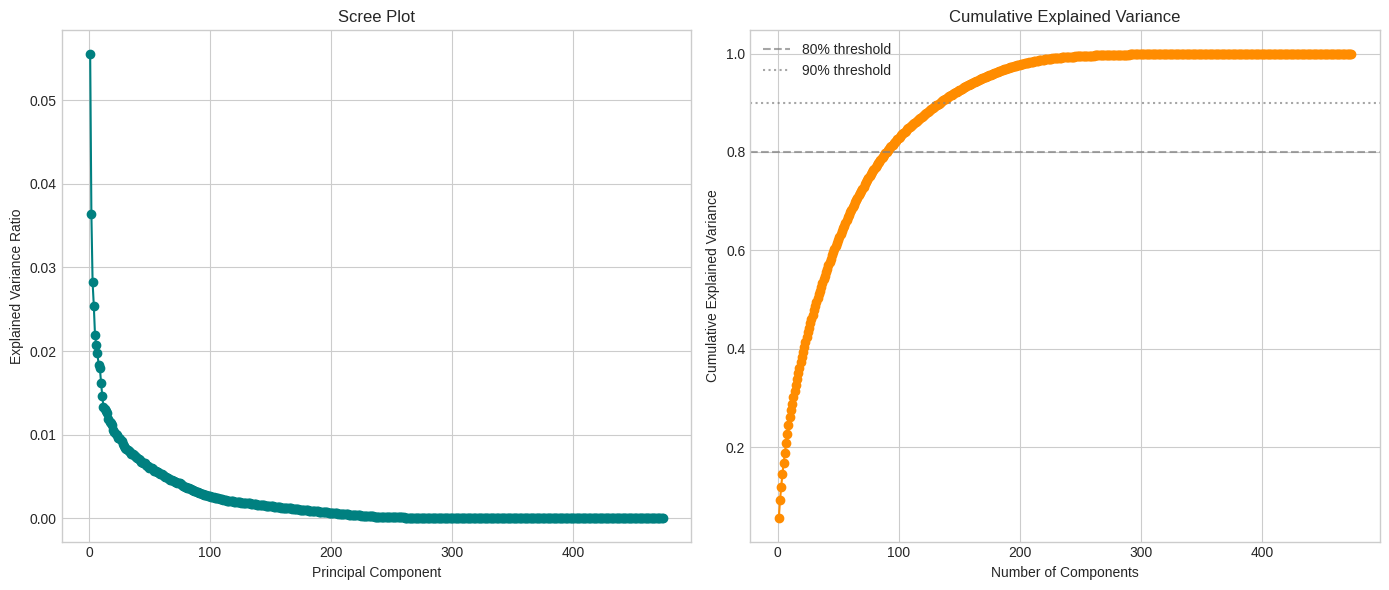

In [54]:
plt.figure(figsize=(14, 6))

# Scree plot (left)
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_var) + 1), explained_var, 'o-', color='teal')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)

# Cumulative (right)
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'o-', color='darkorange')
plt.axhline(y=0.80, color='gray', linestyle='--', alpha=0.7, label='80% threshold')
plt.axhline(y=0.90, color='gray', linestyle=':', alpha=0.7, label='90% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

How many components for common thresholds?

In [55]:
thresholds = [0.70, 0.80, 0.85, 0.90, 0.95]

for thresh in thresholds:
    n_comp = np.argmax(cumulative_var >= thresh) + 1
    actual_var = cumulative_var[n_comp-1]
    print(f"To keep ≥ {thresh:.0%} variance → {n_comp} components "
          f"({actual_var:.3%} actual)")

# Also show what 80 fixed components would give
if n_features >= 80:
    print(f"\nFirst 80 components explain: {cumulative_var[79]:.3%}")

To keep ≥ 70% variance → 65 components (70.245% actual)
To keep ≥ 80% variance → 90 components (80.019% actual)
To keep ≥ 85% variance → 109 components (85.043% actual)
To keep ≥ 90% variance → 134 components (90.004% actual)
To keep ≥ 95% variance → 170 components (95.103% actual)

First 80 components explain: 76.618%


CHOOSE & RUN TARGET PCA

In [56]:
# Recommended: variance-based (change percentage here)
variance_target = 0.85

pca = PCA(n_components=variance_target)
X_pca = pca.fit_transform(X_scaled)

n_components_kept = pca.n_components_
explained_total = pca.explained_variance_ratio_.sum()

print(f"Kept {n_components_kept} components → {explained_total:.1%} variance")
print(f"Shape of transformed data: {X_pca.shape}")

Kept 109 components → 85.0% variance
Shape of transformed data: (1567, 109)


CREATE PCA DATAFRAME

In [60]:
pc_columns = [f"PC{i+1}" for i in range(n_components_kept)]

pca_df = pd.DataFrame(
    X_pca,
    columns=pc_columns,
    index=numeric_df.index
)


In [61]:
dpf.Check(pca_df)

Initating Data Checking Process...
Shape of the DataFrame:
Shape: 1567 rows, 109 columns

         Dtype  Missing  Missing %  Unique
PC1    float64        0        0.0    1567
PC2    float64        0        0.0    1567
PC3    float64        0        0.0    1567
PC4    float64        0        0.0    1567
PC5    float64        0        0.0    1567
...        ...      ...        ...     ...
PC105  float64        0        0.0    1567
PC106  float64        0        0.0    1567
PC107  float64        0        0.0    1567
PC108  float64        0        0.0    1567
PC109  float64        0        0.0    1567

[109 rows x 4 columns]

First 5 rows:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -1.694712  2.925447  3.890939 -2.592471 -0.011955 -1.319868 -1.763873   
1 -2.247247  0.877508  2.881584 -2.065130 -0.299737 -1.633935 -2.220462   
2  0.442979  1.232598  1.145116 -0.383467  0.603869  2.110748 -2.234793   
3  1.158448  5.126746  4.273152 -3.291961  2.816447  2.

,Dtype,Missing,Missing %,Unique
PC1,float64,0,0.0,1567
PC2,float64,0,0.0,1567
PC3,float64,0,0.0,1567
PC4,float64,0,0.0,1567
PC5,float64,0,0.0,1567
...,...,...,...,...
PC105,float64,0,0.0,1567
PC106,float64,0,0.0,1567
PC107,float64,0,0.0,1567
PC108,float64,0,0.0,1567


If 'Pass/Fail' column exists, add it back to the PCA DataFrame

In [62]:
# Bring back the target variable
if 'Pass/Fail' in numeric_df.columns:
    pca_df['Pass/Fail'] = numeric_df['Pass/Fail']
else:
    print("Warning: 'Pass/Fail' not found in numeric_df")

print("PCA DataFrame shape:", pca_df.shape)
display(pca_df.head(6))   # use display() in Jupyter for nicer table

print(pca_df['Pass/Fail'].value_counts(normalize=True))



PCA DataFrame shape: (1567, 110)


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,Pass/Fail
0,-1.694712,2.925447,3.890939,-2.592471,-0.011955,-1.319868,-1.763873,1.793502,0.111791,-1.559919,...,0.339980,1.255613,0.103856,-1.114052,0.274382,1.084933,0.403990,2.192456,-0.551334,-1
1,-2.247247,0.877508,2.881584,-2.065130,-0.299737,-1.633935,-2.220462,1.269828,1.659709,-2.946682,...,2.029559,-0.541109,-0.208939,-1.294567,-0.655076,-1.957079,0.200102,0.592839,-0.554380,-1
2,0.442979,1.232598,1.145116,-0.383467,0.603869,2.110748,-2.234793,0.407526,0.657794,-2.762054,...,0.267253,0.000454,-2.080411,-0.158272,-0.253579,1.453014,0.797653,-0.224103,0.599670,1
3,1.158448,5.126746,4.273152,-3.291961,2.816447,2.046978,-7.927497,-2.393805,-11.397941,-6.003949,...,-0.969920,-0.116746,-0.584219,-0.493139,-0.486514,0.237156,-1.596420,1.193012,-0.240277,-1
4,0.753874,2.378387,2.540284,0.009399,1.985742,3.414608,-4.568914,-0.949357,-3.610698,2.437743,...,-1.228133,-1.362514,-0.618963,-1.461269,-1.815453,0.998426,0.445123,1.110251,-0.926230,-1
5,2.076374,2.875977,3.571428,-2.224759,1.799285,3.529290,-2.443582,2.636688,1.402402,1.704474,...,-0.310089,1.204727,-0.254597,-1.301723,0.501809,-1.204612,0.780904,-0.339320,-0.146621,-1


Pass/Fail
-1    0.933631
 1    0.066369
Name: proportion, dtype: float64


Confirm class distribution

In [63]:
print("\nClass distribution (normalized):")
display(pca_df['Pass/Fail'].value_counts(normalize=True).round(4) * 100)

print("\nRaw counts:")
display(pca_df['Pass/Fail'].value_counts())


Class distribution (normalized):


Pass/Fail
-1    93.36
 1     6.64
Name: proportion, dtype: float64


Raw counts:


Pass/Fail
-1    1463
 1     104
Name: count, dtype: int64

Extract & Interpret Loadings

In [64]:
# Loadings = how much each original feature contributes to each PC
feature_names = numeric_df.drop(columns=['Pass/Fail']).columns \
    if 'Pass/Fail' in numeric_df.columns else numeric_df.columns

loadings = pd.DataFrame(
    pca.components_.T,                     # shape: (n_features, n_components)
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=feature_names
)

print("\nLoadings DataFrame shape:", loadings.shape)

# Show absolute top 8 contributors per PC (most influential sensors)
print("\nTop contributing features per PC (by absolute loading):")
for pc in loadings.columns[:6]:           # look at first 6 PCs
    top = loadings[pc].abs().sort_values(ascending=False).head(8)
    print(f"\n{pc}:")
    print(top.round(4))

# Optional: save loadings for later inspection
# loadings.to_csv("secom_pca_loadings.csv")


Loadings DataFrame shape: (474, 109)

Top contributing features per PC (by absolute loading):

PC1:
Feature_197    0.1857
Feature_480    0.1855
Feature_208    0.1849
Feature_200    0.1797
Feature_344    0.1783
Feature_205    0.1772
Feature_333    0.1761
Feature_337    0.1740
Name: PC1, dtype: float64

PC2:
Feature_300    0.2005
Feature_165    0.2002
Feature_435    0.1992
Feature_437    0.1992
Feature_436    0.1979
Feature_432    0.1971
Feature_301    0.1954
Feature_166    0.1937
Name: PC2, dtype: float64

PC3:
Feature_421    0.1965
Feature_283    0.1957
Feature_148    0.1953
Feature_153    0.1905
Feature_288    0.1904
Feature_284    0.1902
Feature_17     0.1902
Feature_149    0.1899
Name: PC3, dtype: float64

PC4:
Feature_422    0.1946
Feature_428    0.1943
Feature_149    0.1936
Feature_284    0.1934
Feature_155    0.1925
Feature_290    0.1914
Feature_288    0.1888
Feature_153    0.1887
Name: PC4, dtype: float64

PC5:
Feature_519    0.2889
Feature_385    0.2888
Feature_247    0.2887
F

Biplot – Loadings + Scores (very useful for SECOM)

In [65]:
# ─── Debug: Check exact column names in pca_df ───────────────────────
print("pca_df columns:")
print(pca_df.columns.tolist())

print("\nFirst few rows to confirm:")
display(pca_df.head(3))

print("\nDoes 'PC1' exist?", 'PC1' in pca_df.columns)
print("Does 'PC1' (case sensitive) exist?", any(col == 'PC1' for col in pca_df.columns))
print("Sample PC-like columns:", [col for col in pca_df.columns if 'PC' in col or 'pc' in col][:6])

pca_df columns:
['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36', 'PC37', 'PC38', 'PC39', 'PC40', 'PC41', 'PC42', 'PC43', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48', 'PC49', 'PC50', 'PC51', 'PC52', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57', 'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'PC64', 'PC65', 'PC66', 'PC67', 'PC68', 'PC69', 'PC70', 'PC71', 'PC72', 'PC73', 'PC74', 'PC75', 'PC76', 'PC77', 'PC78', 'PC79', 'PC80', 'PC81', 'PC82', 'PC83', 'PC84', 'PC85', 'PC86', 'PC87', 'PC88', 'PC89', 'PC90', 'PC91', 'PC92', 'PC93', 'PC94', 'PC95', 'PC96', 'PC97', 'PC98', 'PC99', 'PC100', 'PC101', 'PC102', 'PC103', 'PC104', 'PC105', 'PC106', 'PC107', 'PC108', 'PC109', 'Pass/Fail']

First few rows to confirm:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,Pass/Fail
0,-1.694712,2.925447,3.890939,-2.592471,-0.011955,-1.319868,-1.763873,1.793502,0.111791,-1.559919,...,0.339980,1.255613,0.103856,-1.114052,0.274382,1.084933,0.403990,2.192456,-0.551334,-1
1,-2.247247,0.877508,2.881584,-2.065130,-0.299737,-1.633935,-2.220462,1.269828,1.659709,-2.946682,...,2.029559,-0.541109,-0.208939,-1.294567,-0.655076,-1.957079,0.200102,0.592839,-0.554380,-1
2,0.442979,1.232598,1.145116,-0.383467,0.603869,2.110748,-2.234793,0.407526,0.657794,-2.762054,...,0.267253,0.000454,-2.080411,-0.158272,-0.253579,1.453014,0.797653,-0.224103,0.599670,1



Does 'PC1' exist? True
Does 'PC1' (case sensitive) exist? True
Sample PC-like columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']


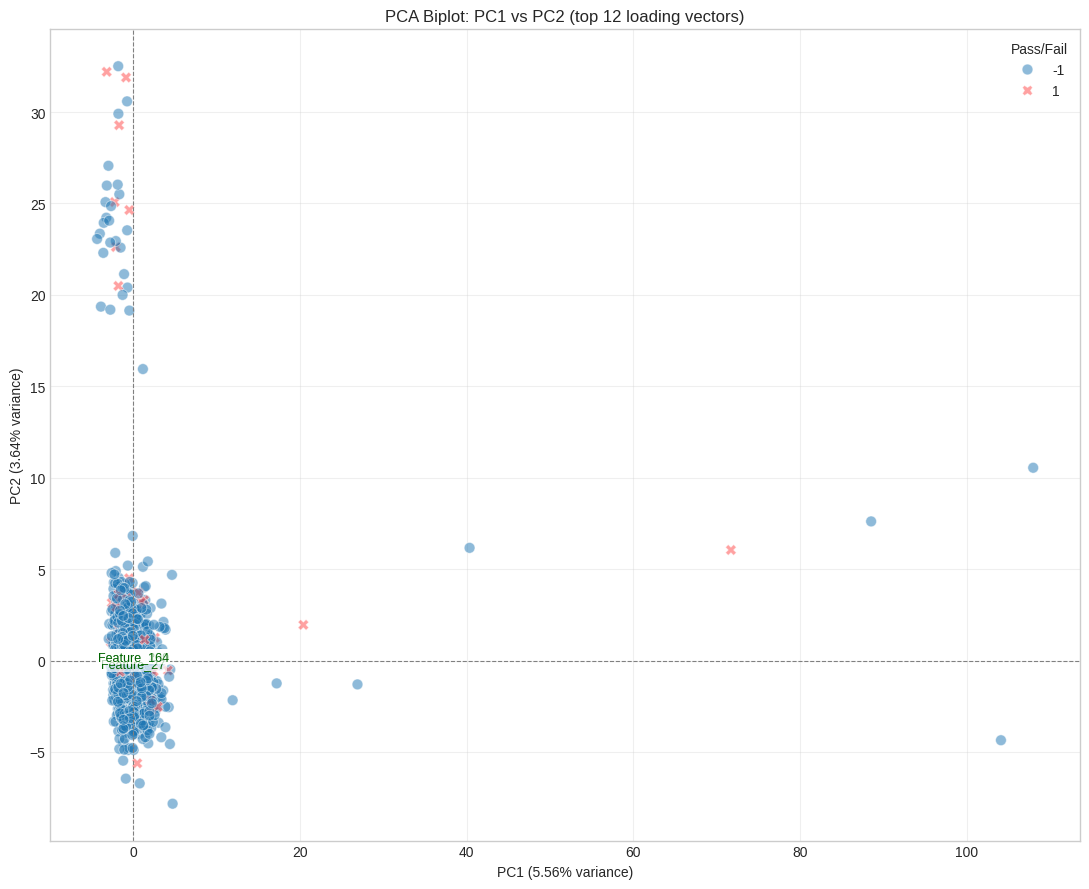

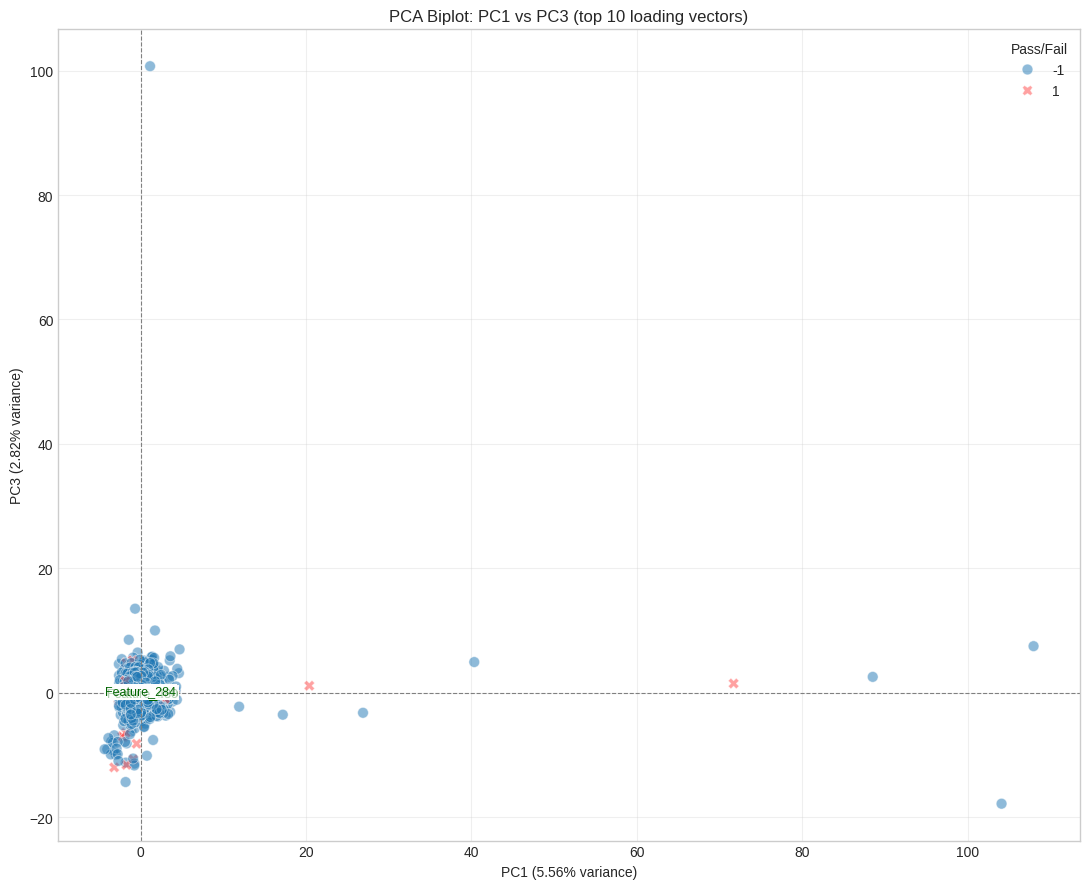

In [66]:
def plot_biplot(pc_x=1, pc_y=2, n_arrows=15):
    """Simple biplot: top contributing variables as arrows + points colored by class"""
    fig, ax = plt.subplots(figsize=(11, 9))
    
    # Scores (transformed data points)
    sns.scatterplot(
        data=pca_df,
        x=f'PC{pc_x}', y=f'PC{pc_y}',
        hue='Pass/Fail',
        style='Pass/Fail',
        palette={-1: '#1f77b4', 1: '#ff4444'},   # blue=pass, red=fail
        alpha=0.5,
        s=60,
        ax=ax
    )
    
    # Loadings arrows – only show top contributors to avoid clutter
    top_features = loadings[f'PC{pc_x}'].abs().add(loadings[f'PC{pc_y}'].abs()).nlargest(n_arrows).index
    
    for feat in top_features:
        lx, ly = loadings.loc[feat, f'PC{pc_x}'], loadings.loc[feat, f'PC{pc_y}']
        ax.arrow(0, 0, lx, ly,
                 color='darkgreen', alpha=0.7, head_width=0.015, length_includes_head=True)
        ax.text(lx*1.12, ly*1.12, feat,
                color='darkgreen', ha='center', va='center', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))
    
    ax.set_xlabel(f'PC{pc_x} ({explained_var[pc_x-1]:.2%} variance)')
    ax.set_ylabel(f'PC{pc_y} ({explained_var[pc_y-1]:.2%} variance)')
    ax.set_title(f'PCA Biplot: PC{pc_x} vs PC{pc_y} (top {n_arrows} loading vectors)')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='gray', lw=0.8, ls='--')
    ax.axvline(0, color='gray', lw=0.8, ls='--')
    plt.legend(title='Pass/Fail')
    plt.tight_layout()
    plt.show()

# Plot first few pairs
plot_biplot(1, 2, n_arrows=12)
plot_biplot(1, 3, n_arrows=10)   # optional

Score Plots – Looking for separation by class

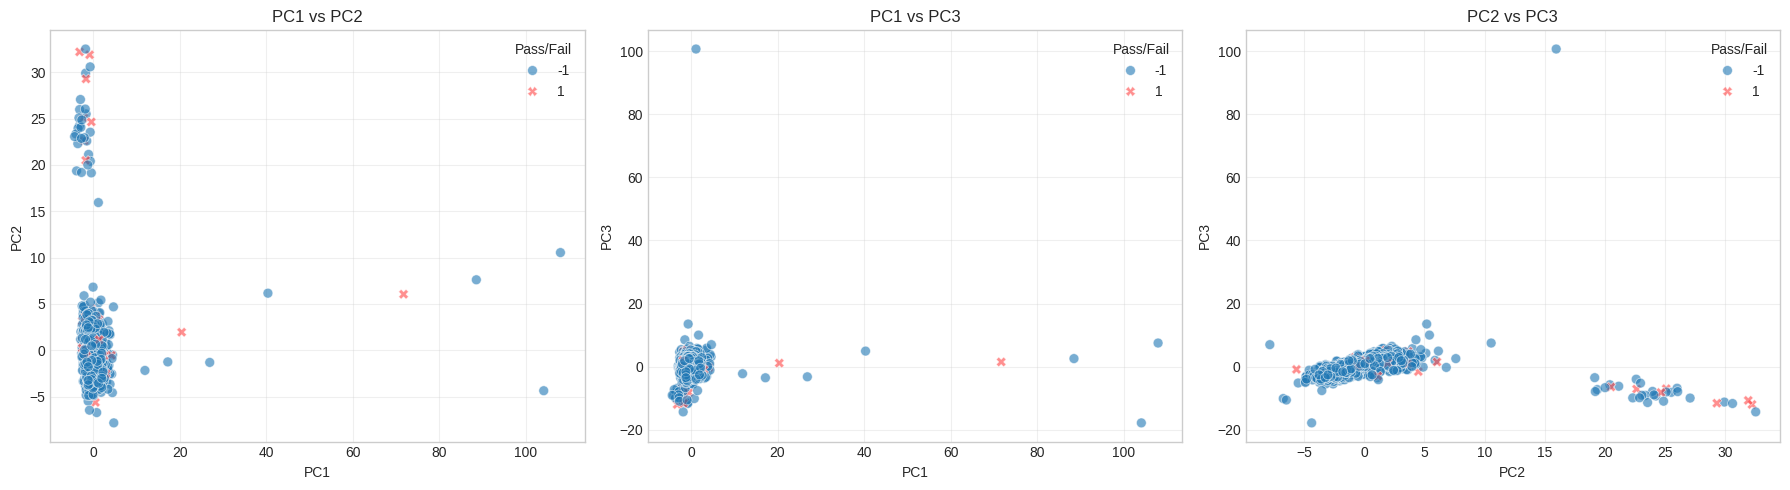

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (ax, pc_x, pc_y) in enumerate(zip(axes, [1,1,2], [2,3,3])):
    sns.scatterplot(
        data=pca_df,
        x=f'PC{pc_x}', y=f'PC{pc_y}',
        hue='Pass/Fail',
        style='Pass/Fail',
        palette={-1: '#1f77b4', 1: '#ff4444'},
        alpha=0.6,
        s=50,
        ax=ax
    )
    ax.set_title(f'PC{pc_x} vs PC{pc_y}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Variance explained by the selected components

Number of components kept: 109
Total variance explained: 85.043%


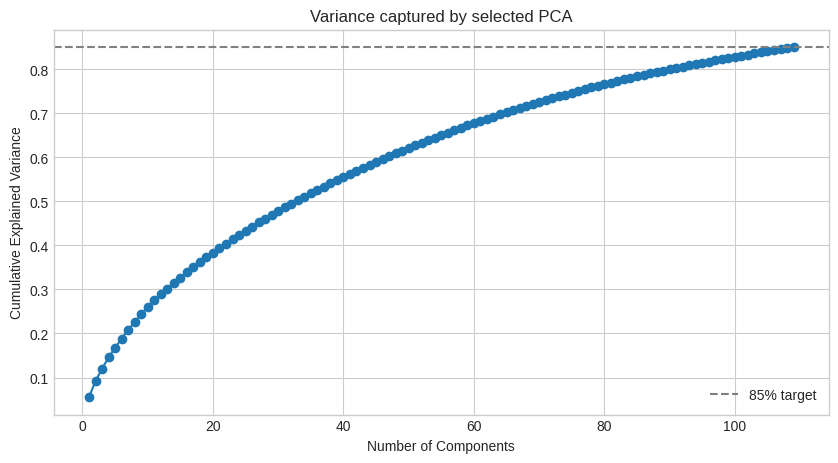

In [75]:
print(f"Number of components kept: {pca.n_components_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.3%}")

plt.figure(figsize=(10,5))
plt.plot(range(1, pca.n_components_+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
plt.axhline(y=0.85, color='gray', ls='--', label='85% target')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Variance captured by selected PCA')
plt.grid(True)
plt.legend()
plt.show()

Clustering in low-dimensional PCA space (exploratory)

In [67]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Use top 3–5 PCs (adjust based on your cumulative variance)

In [68]:
n_cluster_pcs = min(5, pca.n_components_)
X_for_clust = pca_df[[f'PC{i+1}' for i in range(n_cluster_pcs)]]

Try 2–6 clusters

In [69]:
sil_scores = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_for_clust)
    sil = silhouette_score(X_for_clust, labels)
    sil_scores.append(sil)
    print(f"k={k} → silhouette={sil:.3f}")

k=2 → silhouette=0.930
k=3 → silhouette=0.797
k=4 → silhouette=0.800
k=5 → silhouette=0.441
k=6 → silhouette=0.446


Pick best (highest silhouette) or domain choice (e.g. k=2 or 3)

In [70]:
best_k = np.argmax(sil_scores) + 2
print(f"\nBest silhouette at k={best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(X_for_clust)


Best silhouette at k=2


Visualize

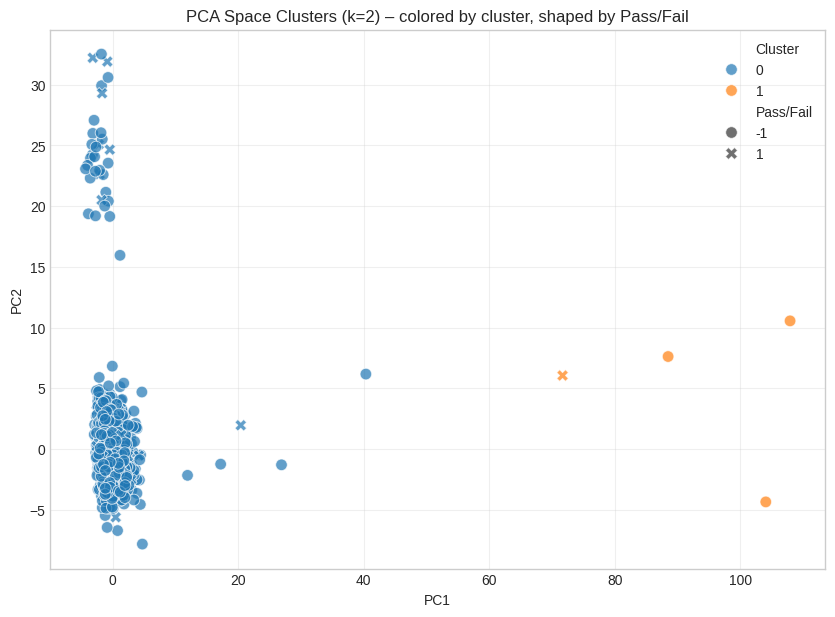

In [71]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    palette='tab10',
    style='Pass/Fail',
    alpha=0.7,
    s=70
)
plt.title(f'PCA Space Clusters (k={best_k}) – colored by cluster, shaped by Pass/Fail')
plt.grid(True, alpha=0.3)
plt.show()

Crosstab: how clusters relate to actual Pass/Fail

In [72]:
print("\nCluster vs Pass/Fail crosstab:")
display(pd.crosstab(pca_df['Cluster'], pca_df['Pass/Fail'], normalize='index').round(3) * 100)


Cluster vs Pass/Fail crosstab:


Pass/Fail,-1,1
Cluster,,
0,93.4,6.6
1,75.0,25.0


SAVE DATAFRAMES FOR LATER:

In [76]:
# 1. Original cleaned features — most important for feature selection
numeric_df.to_csv("secom_numeric_cleaned_475features.csv", index=False)
print("Saved: secom_numeric_cleaned_475features.csv")

# 2. PCA-transformed version — for direct modeling comparison
pca_df.to_csv("secom_pca_transformed_85pct.csv", index=False)
print("Saved: secom_pca_transformed_85pct.csv")

# 3. Loadings (for interpretation & possible manual selection)
loadings.to_csv("secom_pca_loadings.csv")
print("Saved: secom_pca_loadings.csv")


# Save the fitted scaler (useful if you ever need to transform new data)
import joblib
joblib.dump(scaler, "secom_scaler.pkl")
print("Saved scaler: secom_scaler.pkl")

# Save the fitted PCA object itself (can transform new data later)
joblib.dump(pca, "secom_pca_model_85pct.pkl")
print("Saved PCA object: secom_pca_model_85pct.pkl")

Saved: secom_numeric_cleaned_475features.csv
Saved: secom_pca_transformed_85pct.csv
Saved: secom_pca_loadings.csv
Saved scaler: secom_scaler.pkl
Saved PCA object: secom_pca_model_85pct.pkl


Optional next steps / reminders

In [77]:
print("""
Next logical steps after this PCA exploration:
  • Use top PCs or top-loading original features → train classifier (e.g. RandomForest, XGBoost, LogisticRegression with class_weight='balanced')
  • Try anomaly detection (Isolation Forest, Autoencoder) instead of classification — failures are rare
  • Compare model performance before/after PCA
  • Investigate top-loading sensors → domain interpretation (which process steps matter most?)
  For Boruta / RFE / XGBoost importance → need numeric_df (original features)
  For PCA-based modeling baseline → need pca_df
  For interpretation / storytelling → loadings
""")


Next logical steps after this PCA exploration:
  • Use top PCs or top-loading original features → train classifier (e.g. RandomForest, XGBoost, LogisticRegression with class_weight='balanced')
  • Try anomaly detection (Isolation Forest, Autoencoder) instead of classification — failures are rare
  • Compare model performance before/after PCA
  • Investigate top-loading sensors → domain interpretation (which process steps matter most?)
  For Boruta / RFE / XGBoost importance → need numeric_df (original features)
  For PCA-based modeling baseline → need pca_df
  For interpretation / storytelling → loadings



### Key PCA Insights

- Dimensionality reduced from 475 features to X components while retaining Y% variance → substantial compression due to sensor redundancy.
- Cumulative variance curve shows rapid early gains → most information in first ~50–100 directions.
- Exploratory clustering in PCA space reveals **two regimes**:
  - Large "normal" cluster (93% pass).
  - Smaller high-risk cluster (25% fail rate) → potential anomalous process state.
- Takeaway: PCA effectively captures variance and subgroup structure, but linear separation of fails is limited → motivates supervised feature selection or non-linear methods next.